<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%load_ext tensorboard

import scipy
print('Using SciPy Version:', scipy.__version__) # Should be 1.1.0

import os
from pathlib import Path
from PIL import Image
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import random

# EfficientNetB7
! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB7

Using TensorFlow Version: 2.3.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Using SciPy Version: 1.4.1
Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.1)


In [166]:
# Check if the hardware accelerator is set to GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

GPU device not found


In [167]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V6/Training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V6/Validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V6/Testing'

In [169]:
# Saved weights
checkpoint_filepath = 'covid19_ct_model.h5'

In [170]:
# Initialize constants
CLASSES = ['COVID-19 Positive', 'COVID-19 Negative']

# Need 3 grayscale channels to be compatible w/ imagenet weights (RGB)
CHANNELS = 3
COLOR_MODE = 'rgb'
# ---------------------------------------------------------
# Should be 224 x 224? Found online 256 x 256 more popular
# ---------------------------------------------------------
IMG_WIDTH, IMG_HEIGHT = 224, 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
DARK_IMG_PXL_THRESHOLD = 200
MIN_NUM_CONTOURS = 5
SLICE_RANGE = 0.1

BATCH_SIZE = 50
EPOCHS = 5

# METRICS = ['accuracy',
#            Precision(name='precision'),
#            Recall(name='recall')]
METRICS = ['accuracy',
           Precision(),
           Recall()]

COVID_THRESHOLD = 0.05
EQUIDDST_MEAS = 0.5
NORMAL_THRESHOLD = 0.95

PERCENTAGE_FACTOR = 100;

**Data Preprocessing**

In [171]:
def load_data(train_dir, val_dir):
    train_img_paths = []
    val_img_paths = []

    for root, dirs, files in os.walk(train_dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            train_img_paths.append(abs_path)

    for root, dirs, files in os.walk(val_dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            val_img_paths.append(abs_path)

    return train_img_paths, val_img_paths

In [172]:
# Crop the image along the contours
def lungs_auto_crop(img_path=None, img_array=None, is_nii=False, plot=False):
    cropped_img = None

    if img_path is not None:
        img = cv2.imread(img_path)
        img2 = img.copy()
    else:
        img = img_array
        img2 = img_array.copy()

    # print('Max pixel value:', np.max(img2))
    if np.max(img2) > DARK_IMG_PXL_THRESHOLD:
        binary_img_pxl_threshold = 110
    else:
        return None        

    grayscale_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    smoothed_img = cv2.GaussianBlur(grayscale_img, (5, 5), 0)

    if is_nii:
        # binary_img = cv2.adaptiveThreshold(smoothed_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 23, 3)
        binary_img = cv2.threshold(smoothed_img, binary_img_pxl_threshold, 255, cv2.THRESH_BINARY)[1]
    else:
        binary_img = cv2.threshold(smoothed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    kernel = np.ones((8, 8), dtype=np.uint8)
    eroded_img = cv2.erode(binary_img, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]

    # print('# Contours:', len(areas))
    if len(areas) > MIN_NUM_CONTOURS:
        max_index = np.argmax(areas)
        contour = contours[max_index]
        cv2.drawContours(img2, contours, -1, (0, 255, 0), 3)

        x, y, w, h = cv2.boundingRect(contour)
        xmin = x
        xmax = x + w
        ymin = y
        ymax = y + h
        cv2.rectangle(img2, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        cropped_img = img[ymin:ymax, xmin:xmax]

        if plot:
            fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4), constrained_layout=True)
            
            for i, img_filter in enumerate(['Grayscale', 'Smoothed', 'Binary', 'Eroded', 'Dilated', 'Contoured', 'Cropped']):
                axs[i].set_title(img_filter)

            axs[0].imshow(grayscale_img)
            axs[1].imshow(smoothed_img)
            axs[2].imshow(binary_img)
            axs[3].imshow(eroded_img)
            axs[4].imshow(dilated_img)
            axs[5].imshow(img2)
            axs[6].imshow(cropped_img)

            plt.show()

    return cropped_img

In [173]:
def process_png_data(file_paths, crop=False):
    processed_png_imgs = []

    for img_path in file_paths:
        if crop == True:
            cropped_img = lungs_auto_crop(img_path=img_path)
            processed_png_imgs.append(cropped_img)
        else:
            img = cv2.imread(img_path)
            processed_png_imgs.append(img)

    return processed_png_imgs

In [174]:
def process_nii_data(file_paths, crop=False):
    processed_nii_imgs = []
    png_img_paths = []

    for img_path in file_paths:
        img = nib.load(img_path)
        img_array_3d = img.get_fdata()

        # Convert image data type from float64 to uint8
        img_array_3d = cv2.normalize(src=img_array_3d, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        img_array_3d = np.rot90(img_array_3d, 3)
        height, width, slices = img_array_3d.shape
        mid_slice = slices / 2

        lower_slice_bound = int(mid_slice - (SLICE_RANGE * slices))
        upper_slice_bound = int(mid_slice + (SLICE_RANGE * slices))

        for slice_num in range(lower_slice_bound, upper_slice_bound + 1):
            img_array = img_array_3d[:, :, slice_num]
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)

            if crop == True:
                cropped_img = lungs_auto_crop(img_array=img_array, is_nii=True)
                if cropped_img is not None:
                    processed_nii_imgs.append(cropped_img)
                    before, sep, after = img_path.partition('.')
                    png_img_paths.append(before + '_slice_' + str(slice_num) + sep + 'png')
            else:
                processed_nii_imgs.append(img_array)
                before, sep, after = img_path.partition('.')
                png_img_paths.append(before + '_slice_' + str(slice_num) + sep + 'png')
    
    return png_img_paths, processed_nii_imgs

In [175]:
def get_processed_data(img_paths, is_nii=False):
    if is_nii:
        png_img_paths, processed_nii_imgs = process_nii_data(img_paths, crop=True)
        return png_img_paths, processed_nii_imgs

    else:
        processed_png_imgs = process_png_data(img_paths, crop=True)
        return img_paths, processed_png_imgs

In [176]:
def write_imgs(img_paths, processed_imgs, new_dir):
    for i, img_path in enumerate(img_paths):
        # print('img', img_path)
        path_after_dir = r'/'.join(Path(img_path).parts[7:])
        # print('after', path_after_dir)
        final_img_path = Path(os.path.join(new_dir, path_after_dir))
        # print('final', final_img_path)
        final_img_dir = final_img_path.parent
        # print('final parent', final_img_dir)

        if os.path.isdir(str(final_img_dir)) == False:
            print('Directory did not exist')
            os.makedirs(final_img_dir)

        cv2.imwrite(str(final_img_path), processed_imgs[i])

In [177]:
train_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/nii files/COVID-19-20_v2/Train'
val_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/nii files/COVID-19-20_v2/Validation'

new_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/NII FINAL'

train_img_paths, val_img_paths = load_data(train_dir, val_dir)
print('Train length:', len(train_img_paths))
print('Val length:', len(val_img_paths))

new_train_img_paths, processed_train_imgs = get_processed_data(train_img_paths, is_nii=True)
print('New train length:', len(new_train_img_paths))
print('# train imgs processed:', len(processed_train_imgs))
# new_val_img_paths, processed_val_imgs = get_processed_data(val_img_paths, is_nii=True)
# print('New val length:', len(new_val_img_paths))
# print('# val imgs processed:', len(processed_val_imgs))

Train length: 199
Val length: 50
New train length: 1081
# train imgs processed: 1081


In [178]:
write_imgs(new_train_img_paths, processed_train_imgs, new_dir)

Directory did not exist


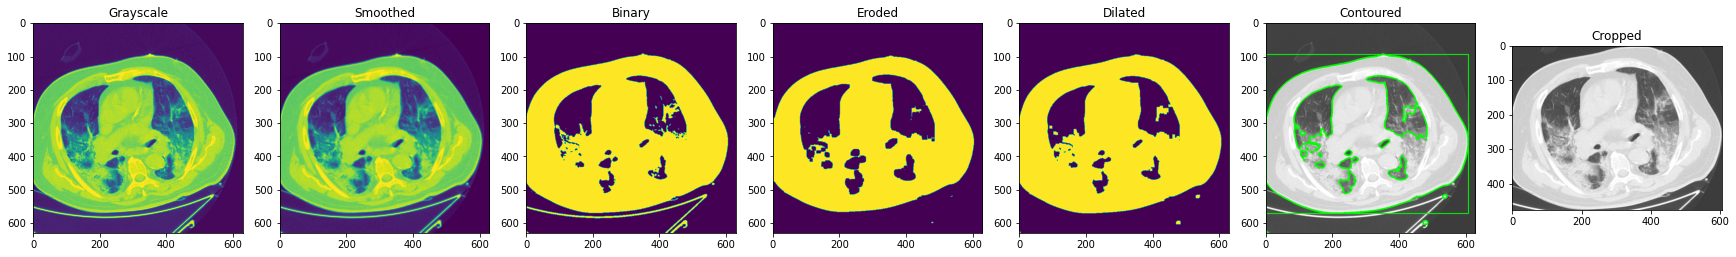

In [ ]:
img_path = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/Internet Images/covid19/real2.jpeg'
cropped_img = lungs_auto_crop(img_path=img_path, plot=True)

In [ ]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,              # Simplify pixel values to be 0-1
                                       horizontal_flip=True,        # Randomly flip images horizontally
                                       vertical_flip=True,          # Randomly flip images vertically
                                       zoom_range=0.15,             # Randomly zoom
                                       shear_range=0.15,            # Shear angle in counter-clockwise direction
                                       rotation_range=20,           # Randomly rotate
                                       width_shift_range=0.15,      # Randomly shift the image left/right
                                       height_shift_range=0.15,     # Randomly shift the image up/down
                                       brightness_range=(0.3, 1.0)) # Randomly adjust the brightness

validation_data_gen = ImageDataGenerator(rescale=1./255)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           color_mode=COLOR_MODE,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='categorical',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               color_mode=COLOR_MODE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=True)

testing_generator = testing_data_gen.flow_from_directory(testing_dir,
                                                         color_mode=COLOR_MODE,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True)

**Building the Model**

In [ ]:
# Create a neural network
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new classifier layers to the end of the base model
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)

    # A final dense layer with a single neuron (binary classification)
    predictions = Dense(1, activation="sigmoid")(x)  

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [ ]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=METRICS)

In [ ]:
# Train the model
def fit_model(model):
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

    early_stopping_cb = EarlyStopping(monitor='val_loss',
                                      min_delta=1e-3,
                                      patience=5,
                                      mode='min',
                                      restore_best_weights=True)
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]

    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    model.load_weights(checkpoint_filepath)
    
    # %tensorboard --logdir logs/fit
    %tensorboard --logdir logs
    
    return history

In [ ]:
# Visualize metrics with graphs
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)
    # axs = axs.ravel()

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

In [ ]:
model = create_model(print_summary=True)
compile_model(model)

In [ ]:
history = fit_model(model)

In [ ]:
evaluate_model(history)

**Predicting Images**

In [ ]:
# testing_img_path = get_testing_image()
# run_diagnosis(model, testing_img_path)

In [ ]:
def convert_img_path_to_array(img_path):
    img = load_img(img_path,
                   color_mode=COLOR_MODE
                   target_size=TARGET_SIZE)
    
    # Convert to Numpy array
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, IMG_WIDTH, IMG_HEIGHT, CHANNELS))

    return img_array

In [ ]:
# Randomly pick and display an unseen image for the network to predict
def get_testing_image():
    # image_index = random.randint(0, len(testing_generator[0][0]))
    # testing_img = testing_generator[0][0][image_index]

    uploaded = files.upload()
   

    return testing_img_path

In [ ]:
# Run a diagnosis to determine if the patient is COVID-19 positive or negative
def run_diagnosis(model, testing_img_path):
    font_settings = {'family': 'DejaVu Sans',
                     'color' : 'red',
                     'weight': 'heavy',
                     'size'  :  15}

    img_array = convert_img_path_to_array(testing_img_path)
    prediction = model.predict(img_array)
    
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((EQUIDDST_MEAS - prediction) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]

        font_settings.update({'color': 'red'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((prediction - EQUIDDST_MEAS) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]
        
        font_settings.update({'color': 'blue'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        font_settings.update({'size' :  11})
        plt.title(network_prediction, fontdict=font_settings)

    print('Prediction:', prediction)
    
    plt.imshow(testing_image)
    plt.show()

Test internet images (unreliable)

In [ ]:
# Pass into run_diagnosis as a param
font_settings = {'family': 'DejaVu Sans',
                 'color' : 'red',
                 'weight': 'heavy',
                 'size'  :  15}

disclaimer = '*** DISCLAIMER ***\n' \
             'Do not rely on this prediction for self-diagnosis. ' \
             'Please check with your local authority services for ' \
             'seeking medical assistance.'

# ax = plt.axes([.65, .6, .2, .2], facecolor='k')

# a = plt.imread('https://lh3.googleusercontent.com/proxy/GoGROGCSVoylCPBvcWy2y8FtuT86Vzsg0cW7ZqW1EHUoKyyStH9dGdxSZV_ya41mbYGbfmm7PRt1QT-MOIe87tcp-m5glt7kteygIHpyz1VqUh2cCNK3AmMXN2S_dSScog3C3u4u6N1p2vieALS-4g')
# plt.imshow(a)
# plt.show()

# matplotlib.widgets.TextBox(ax, disclaimer, initial='', color='.95', hovercolor='1', label_pad=0.01)
plt.text(0.6, 0.7,
        '*** DISCLAIMER ***\n' \
        'Do not rely on this prediction for self-diagnosis. ' \
        'Please check with your local authority services for ' \
        'seeking medical assistance.',
         size=50,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8))
         )

testing_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/Internet Images'

testing_generator = testing_data_gen.flow_from_directory(testing_dir,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='binary',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

print(testing_generator.labels)

# Loop thorough all the image arrays stored in the DirectoryIterator
for i in range(len(testing_generator[0][0])):
    print(str(i + 1) + ": " + testing_generator.filepaths[i])

    true_label_class_index = testing_generator.labels[i]
    # true_label_class_index = testing_generator[0][1][i]
    true_label = CLASSES[true_label_class_index]

    testing_image = testing_generator[0][0][i]
    img_array = testing_image
    
    # Flatten the array
    img_array = img_array.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)

    prediction = model.predict(img_array)
    
    # Safe prediction for COVID-19 positive
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((EQUIDDST_MEAS - prediction) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]

        font_settings.update({'color': 'red'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((prediction - EQUIDDST_MEAS) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]
        
        font_settings.update({'color': 'blue'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        font_settings.update({'size' :  11})
        plt.title(network_prediction, fontdict=font_settings)
    
    print('True Label:', true_label)
    print('Prediction:', prediction)
    
    plt.imshow(testing_image)
    plt.show()

In [ ]:
# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
# plot_map(grad_top1)

# Upload files to test
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded.keys():
#     # print('User uploaded file "{name}" with length {length} bytes'.format(
#     #     name=filename, length=len(uploaded[filename])))

#     img_path = filename
#     img = load_img(img_path,
#                    color_mode=COLOR_MODE
#                    target_size=TARGET_SIZE)
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     print(img_array)

In [ ]:
# #@title Enter Filepath Here:
# filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

# img = image.load_img(filename,
#                      color_mode=COLOR_MODE
#                      target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# y = final_model.predict(x)

# predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
# actual="Normal" if "NORMAL" in filename else "Pneumonia" 

# img=mpimg.imread(filename)
# title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
# plt.title(title_text)
# imgplot=plt.imshow(img)

Confusion Matrix (from https://github.com/haydengunraj/COVIDNet-CT/blob/8599c2a87856326a18bbdf6ffa5987f9c1e64b4b/run_covidnet_ct.py#L213)

In [ ]:
# # Plot confusion matrix
#     fig, ax = plt.subplots()
#     disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion matrix'],
#                                   display_labels=CLASS_NAMES)
#     disp.plot(include_values=True,
#               cmap='Blues', ax=ax,
#               xticks_rotation='horizontal',
#               values_format='.5g')
    
#     plt.show()

GRAD-Cam

In [ ]:
# # Grad-CAM
# ! pip install keras==2.2.0
# ! pip install tensorflow==1.10.0
# ! pip install keras==2.2.2 # EfficientNet PyPi
# ! pip install tensorflow==1.12.0 # EfficientNet PyPi

# Versions that are compatible with vis
# ! pip install keras==2.2.4
# ! pip install tensorflow==1.14.0
# ! pip install keras_applications >= 1.0.7
# https://stackoverflow.com/questions/57773636/no-attribute-set-keras-submodules

# ! pip install vis
# ! pip install scipy==1.1.0

In [ ]:
# ! pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
# import vis

# from vis.utils import utils
# from vis.visualization import visualize_cam

# --------------------------------------------
# FROM https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
# --------------------------------------------
# for i, modifier in enumerate(modifiers):
#     heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
#                             seed_input=bgr_img, grad_modifier=modifier)
#     plt.figure()
#     plt.title(titles[i])
#     # Overlay is used to alpha blend heatmap onto img.
#     jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
#     plt.imshow(overlay(img, jet_heatmap, alpha=0.7))

In [ ]:
# classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
# last_conv_layer_name = 'block7d_add'

# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'

# img = load_img(img_path,
#                color_mode=COLOR_MODE
#                target_size=TARGET_SIZE)

# img               = img_to_array(img)
# # img               = preprocess_input(img)
# y_pred            = model.predict(img[np.newaxis,...])
# class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# # topNclass         = 5
# # for i, idx in enumerate(class_idxs_sorted[:topNclass]):
# #     print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
# #           i + 1,classlabel[idx],idx,y_pred[0,idx]))

# # Utility to search for layer index by name. 
# # ***********  Alternatively we can specify this as -1 since it corresponds to the last layer.  ***************
# layer_idx = utils.find_layer_idx(model, 'dense_8')
# # Swap softmax with linear
# model.layers[layer_idx].activation = tf.keras.activations.linear
# model = utils.apply_modifications(model)

# penultimate_layer_idx = utils.find_layer_idx(model, "top_conv") 
# class_idx  = class_idxs_sorted[0]
# seed_input = img
# grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
#                            penultimate_layer_idx = penultimate_layer_idx) # TRY TO LEAVE BLANK? -> OR AS 'none'?
#                           #  backprop_modifier     = None)
#                           #  grad_modifier         = None)

In [ ]:
# def plot_map(grads):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
#     axes[0].imshow(_img)
#     axes[1].imshow(_img)
#     i = axes[1].imshow(grads,cmap="jet", alpha=0.8)
#     fig.colorbar(i)
#     plt.suptitle("Pr(class={}) = {:5.2f}".format(
#                       classlabel[class_idx],
#                       y_pred[0,class_idx]))